In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt

In [11]:
train = pd.read_csv("house-pi/dataset/dataset.csv")
test = pd.read_csv("house-pi/test.csv")
sample_submission = pd.read_csv("house-pi/sample_submission.csv")

In [12]:
target_col = "sale_price"
ID_col = "id"

In [13]:
train = train[train[target_col] < 1_500_000]  # outlier filtreleme

train["sale_date"] = pd.to_datetime(train["sale_date"])
test["sale_date"] = pd.to_datetime(test["sale_date"])
train["sale_year"] = train["sale_date"].dt.year
train["sale_month"] = train["sale_date"].dt.month
test["sale_year"] = test["sale_date"].dt.year
test["sale_month"] = test["sale_date"].dt.month

train["building_age"] = train["sale_year"] - train["year_built"]
test["building_age"] = test["sale_year"] - test["year_built"]

train["price_per_sqft"] = train[target_col] / (train["sqft"] + 1)
test["price_per_sqft"] = 0  # testte bilinmiyor

train["living_area_per_room"] = train["sqft"] / (train["beds"] + 1)
test["living_area_per_room"] = test["sqft"] / (test["beds"] + 1)

categorical_cols = [
    "city", "zoning", "subdivision", "present_use", "view_rainier", "view_olympics",
    "view_cascades", "view_territorial", "view_skyline", "view_sound", "view_lakewash",
    "view_lakesamm", "view_otherwater", "view_other", "submarket"
]

num_cols = train.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col not in [target_col, ID_col]]

for col in categorical_cols:
    if col in train.columns:
        train[col] = train[col].astype(str).fillna("missing")
        test[col] = test[col].astype(str).fillna("missing")

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])
test[categorical_cols] = encoder.transform(test[categorical_cols])

full_features = list(dict.fromkeys(num_cols + categorical_cols))

train_clean = train.dropna(subset=full_features + [target_col])
X = train_clean[full_features]
y = np.log1p(train_clean[target_col])  # log dönüşümü
test_X = test[full_features]


In [14]:
def safe_expm1(preds, clip_min=-10, clip_max=15):
    clipped = np.clip(preds, clip_min, clip_max)
    return np.expm1(clipped)

In [15]:
def winkler_score(y_true, lower, upper, alpha=0.1):
    score = []
    for yt, l, u in zip(y_true, lower, upper):
        if np.isnan(l) or np.isnan(u) or np.isnan(yt):
            continue
        if np.isinf(l) or np.isinf(u) or np.isinf(yt):
            continue
        if l <= yt <= u:
            score.append(u - l)
        else:
            penalty = (2 / alpha) * (l - yt) if yt < l else (2 / alpha) * (yt - u)
            score.append((u - l) + penalty)
    return np.mean(score) if score else float('nan')


In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_lower = lgb.LGBMRegressor(
        objective='quantile', alpha=0.05,
        learning_rate=0.03, n_estimators=2000,
        min_child_samples=40, max_depth=5,
        subsample=0.7, colsample_bytree=0.6,
        reg_alpha=1.0, reg_lambda=2.0,
        random_state=42
    )
    model_upper = lgb.LGBMRegressor(
        objective='quantile', alpha=0.95,
        learning_rate=0.03, n_estimators=2000,
        min_child_samples=40, max_depth=5,
        subsample=0.7, colsample_bytree=0.6,
        reg_alpha=1.0, reg_lambda=2.0,
        random_state=42
    )

    model_lower.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50)])
    model_upper.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50)])

    pred_lower = safe_expm1(model_lower.predict(X_val))
    pred_upper = safe_expm1(model_upper.predict(X_val))
    y_val_exp = np.expm1(y_val)

    score = winkler_score(y_val_exp, pred_lower, pred_upper)
    print(f"Fold {fold+1} Winkler Score: {score}")
    scores.append(score)

print(f"K-Fold CV Validation Winkler Score: {np.mean(scores)} ± {np.std(scores)}")

# Son foldun modellerini submission için sakla
final_model_lower = model_lower
final_model_upper = model_upper


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 120529, number of used features: 47
[LightGBM] [Info] Start training from score 12.125410
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [18]:
pi_lower = safe_expm1(final_model_lower.predict(test_X))
pi_upper = safe_expm1(final_model_upper.predict(test_X))

submission = pd.DataFrame({
    "id": test[ID_col],
    "pi_lower": pi_lower,
    "pi_upper": pi_upper
})

submission.to_csv("submission.csv", index=False)
print("✅ Yeni submission dosyası oluşturuldu.")


✅ Yeni submission dosyası oluşturuldu.


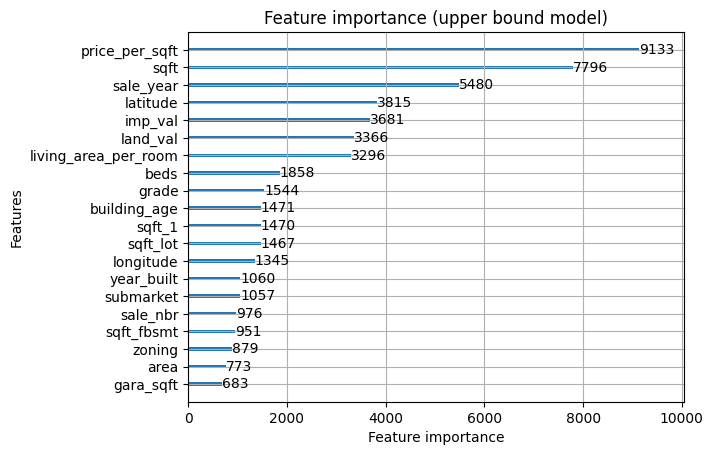

In [19]:
lgb.plot_importance(final_model_upper, max_num_features=20)
plt.title("Feature importance (upper bound model)")
plt.show()
